this notebook aims to use basic tensorflow to model the titanic data with a neural network. And take it to the tensorboard and explore that. 

In [1]:
import sys
import logging

import numpy as np
import scipy as sp
import sklearn

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [4]:
import category_encoders as ce

# Hyperparameter Tuning
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold,train_test_split

# Performance Measures
from sklearn.metrics import accuracy_score,classification_report,make_scorer
# Global Variables
rnd_state = 42
skfold = StratifiedKFold(n_splits=5)


%config IPCompleter.greedy=True
import seaborn as sns


In [3]:
#importlib.reload(tit)

In [6]:
#import go1_utils as go
import tit_utils as tit
import importlib
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder

In [7]:
path= "../data/"
train_O,test_O = tit.load_tit(path)
df = train_O.copy()
labels = df.Survived


In [8]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df.shape

(891, 12)

In [10]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
# preprocessing routine gets things ready for a linear model????
list1 = ["Title","Embarked","Deck"]  # cols to one hot
list2 = ['Fare',"Age_nonull","FamilySize","AgeBin",'Pclass']  # cols to scale 
# cols to drop
list3 = ["Survived","Name","PassengerId","Pclass", "Sex","Age","Ticket","Cabin","Embarked","Title","Deck","Fare","Age_nonull","AgeBin","FamilySize"]  
### try with scaled agebin,FamilySize, and Pclass or mayber onehot it


def last_minute(df):
    # make a few changes
    df['FamilySize'] = df["SibSp"] + df['Parch']
    #df = tit.pp_Pclass(df)
    df = tit.oneHot(df,list1)
    df = tit.scaleNumeric(df,list2)
    df = df.drop(list3,axis=1)
    return df

def init_pipeline(df):
    df = tit.pp_Embarked(df)
    df = tit.pp_Name(df)
    df = tit.pp_Fare(df)
    df = tit.pp_Sex(df)
    df = tit.pp_Cabin(df)
    df = tit.pp_Age(df)
    df = tit.pp_AgeBin(df)
    df = last_minute(df)
    return df

In [13]:
df.shape

(891, 12)

In [14]:
dff = init_pipeline(df)

In [15]:
print(dff.columns)
print("number of nulls = {}".format(np.sum(np.sum(dff.isnull()))))
dff.head()


Index(['SibSp', 'Parch', 'is_Female', 'Title_Capt', 'Title_Col', 'Title_Don',
       'Title_Dr', 'Title_Jonkheer', 'Title_Lady', 'Title_Major',
       'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr',
       'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir', 'Title_the Countess',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Deck_A', 'Deck_B', 'Deck_C',
       'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_UNK',
       'Fare_scaled', 'Age_nonull_scaled', 'FamilySize_scaled',
       'AgeBin_scaled', 'Pclass_scaled'],
      dtype='object')
number of nulls = 0


,SibSp,Parch,is_Female,Title_Capt,Title_Col,Title_Don,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Embarked_C,Embarked_Q,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_UNK,Fare_scaled,Age_nonull_scaled,FamilySize_scaled,AgeBin_scaled,Pclass_scaled
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.564109,-0.529625,0.059160,-0.472453,0.827377
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0.942548,0.656571,0.059160,0.649099,-1.566107
2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.548227,-0.233076,-0.560975,-0.098603,0.827377
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0.514708,0.434159,0.059160,0.275248,-1.566107
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,-0.545285,0.434159,-0.560975,0.275248,0.827377


In [16]:
X_train, X_test, y_train, y_test = train_test_split(dff, labels, test_size=0.33, random_state=42)

In [56]:
#######################  DELETE FROM HERE TO .................................
## this is follow along with scipy video @
##  https://www.youtube.com/watch?v=Tr4DYo4v5AY&list=PLYx7XA2nY5GcDQblpQ_M1V3PQPoLWiDAC&index=34

In [18]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,is_Female,Deck,Age_nonull,AgeBin,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,UNK,22.0,4,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1,C,38.0,7,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,UNK,26.0,5,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1,C,35.0,6,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,UNK,35.0,6,0


In [20]:
df["Age"].dropna()

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
885    39.0
886    27.0
887    19.0
889    26.0
890    32.0
Name: Age, Length: 714, dtype: float64

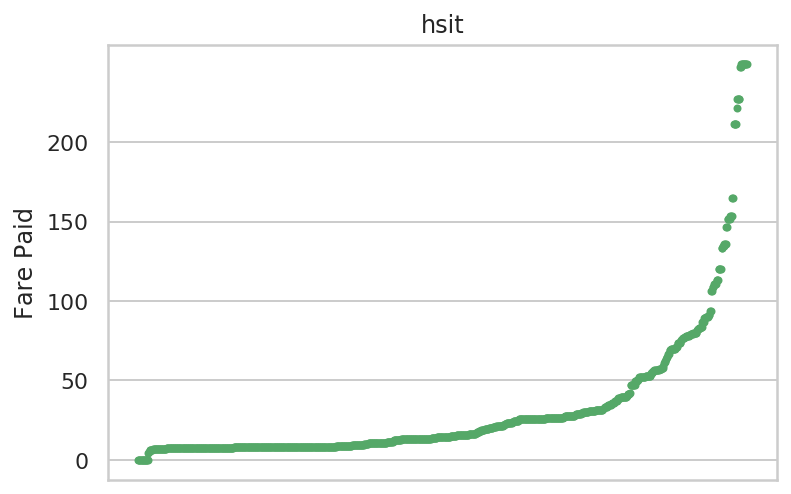

In [32]:
fig, ax = plt.subplots()
_ = ax.set_title("hsit")
_ = ax.plot(np.sort(df["Fare"].dropna()), "go", markersize=3)
_ = ax.set_ylabel("Fare Paid")
_ = ax.set_yticks(list(range(0,int(df.Fare.max()),50)))
_ = ax.set_xticks([])

In [27]:
df.Fare.max()

249.00622000000033

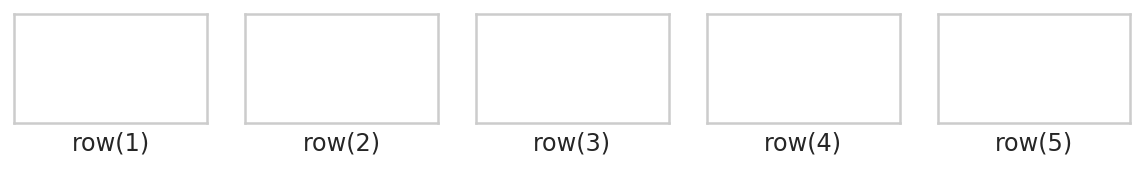

In [55]:
fig, ax = plt.subplots(1,5, figsize=(10,1))

for i in range(5):
    ax[i].set_xlabel(f"row({i+1})")
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    


In [ ]:
#######################   HERE  #########################################

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Dropout

In [61]:
model1 = Sequential([
    Dense(128, input_shape=(37,)),
    Activation('relu'),
    Dense(32),
    Activation("relu"),
    Dense(1),
    Activation("sigmoid")
])

model1.compile(optimizer="rmsprop",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [1]:
history = model1.fit(X_train,y_train, validation_data = (X_test, y_test),batch_size=64,epochs = 50)

NameError: name 'model1' is not defined

In [63]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model1,X_train,y_train,cv=5,scoring="accuracy")

TypeError: Cannot clone object '<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f228869c4e0>' (type <class 'tensorflow.python.keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' methods.